In [1]:
import pandas as pd
import numpy as np
import pprint as pp
import pgeocode as pg
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import uniform, randint
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,Tipo,FechaConstruccion,FechaReforma,Plantas,Plan,PAU,CatParcela,PerimParcela,Superficie,...,AguaCorriente,FosaSeptica,Situacion,CP,ProxCarretera,ProxCallePrincipal,ProxViasTren,Estado,RatingEstrellas,Precio
0,1,Chalet individual,2003,2003,2,Antiguo,0,Residencial unifamiliar,79.25,785.03,...,1,0,Interior,60061,0,0,0,5,3.5,375497
1,2,Chalet individual,1976,1976,1,Antiguo,0,Residencial unifamiliar,97.54,891.87,...,1,0,Frontal 2 lados,50018,0,1,0,8,3.0,339946
2,3,Chalet individual,2001,2002,2,Antiguo,0,Residencial unifamiliar,82.91,1045.16,...,1,0,Interior,60061,0,0,0,5,3.5,402511
3,4,Chalet individual,1915,1970,2,Nuevo,0,Residencial unifamiliar,73.15,887.22,...,1,0,Esquina,62451,0,0,0,5,3.5,272706
4,5,Chalet individual,2000,2000,2,Antiguo,0,Residencial unifamiliar,102.41,1324.80,...,1,0,Frontal 2 lados,60706,0,0,0,5,4.0,450236


In [3]:
variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']
print('Variables reales: ', variables_reales)
print('Variables categoricas: ', variables_categoricas)
print('Variables enteras: ', variables_enteras)

Variables reales:  Index(['PerimParcela', 'Superficie', 'RatingEstrellas'], dtype='object')
Variables categoricas:  Index(['Tipo', 'Plan', 'CatParcela', 'Formato', 'TipoDesnivel', 'Desnivel',
       'Situacion'],
      dtype='object')
Variables enteras:  Index(['Id', 'FechaConstruccion', 'FechaReforma', 'Plantas', 'PAU', 'Aseos',
       'Habitaciones', 'Garaje', 'Piscina', 'Vallada', 'CallePavimentada',
       'Callejon', 'GasNatural', 'AguaCorriente', 'FosaSeptica', 'CP',
       'ProxCarretera', 'ProxCallePrincipal', 'ProxViasTren', 'Estado',
       'Precio'],
      dtype='object')


In [4]:
def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[:3]
    df['specific_location'] = df['CP']
    return df

def zscore_norm_price(df):
    global price_mean, price_std
    price_mean = df['Precio'].mean()
    price_std = df['Precio'].std()
    df['Precio'] = (df['Precio'] - price_mean) / price_std
    return df

def zscore_norm_price_inverse(np_array):
    global price_mean, price_std
    return np_array * price_std + price_mean

df.drop(['Id', 'AguaCorriente', 'GasNatural', 'FosaSeptica'], axis=1, inplace=True)
df.dropna(inplace=True)
df = extract_postal_hierarchy(df)

df['Reformada'] = df['FechaConstruccion'] != df['FechaReforma']
df['Reformada'] = df['Reformada'].astype(int)

variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']

variables_enteras = variables_enteras.drop(['Precio'])
df = zscore_norm(df, variables_reales)
df = zscore_norm(df, variables_enteras)
df = zscore_norm_price(df)
df = one_hot_encoding(df, variables_categoricas)

df.head()

,FechaConstruccion,FechaReforma,Plantas,PAU,PerimParcela,Superficie,Aseos,Habitaciones,Garaje,Piscina,...,specific_location_60936,specific_location_61528,specific_location_61615,specific_location_61704,specific_location_61705,specific_location_61874,specific_location_62040,specific_location_62447,specific_location_62451,specific_location_62801
0,0.843415,0.691550,1.280128,-0.387936,-0.252488,-0.192850,1.612996,0.969285,0.176781,-0.039968,...,0,0,0,0,0,0,0,0,0,0
1,-0.096667,-0.714172,-0.779924,-0.387936,0.366301,-0.076917,0.537665,-0.312177,0.176781,-0.039968,...,0,0,0,0,0,0,0,0,0,0
2,0.773779,0.639486,1.280128,-0.387936,-0.128663,0.089420,1.612996,-0.312177,0.176781,-0.039968,...,0,0,0,0,0,0,0,0,0,0
3,-2.220555,-1.026555,1.280128,-0.387936,-0.458864,-0.081962,-0.537665,0.328554,0.176781,-0.039968,...,0,0,0,0,0,0,0,0,1,0
4,0.738961,0.535359,1.280128,-0.387936,0.531064,0.392859,1.612996,1.610017,0.176781,-0.039968,...,0,0,0,0,0,0,0,0,0,0


                         FechaConstruccion  FechaReforma   Plantas       PAU   
FechaConstruccion                 1.000000      0.612870  0.129108  0.200842  \
FechaReforma                      0.612870      1.000000  0.187568  0.094040   
Plantas                           0.129108      0.187568  1.000000  0.048371   
PAU                               0.200842      0.094040  0.048371  1.000000   
PerimParcela                      0.124856      0.086501 -0.038367 -0.527749   
...                                    ...           ...       ...       ...   
specific_location_61874           0.002414     -0.028665  0.072531  0.145819   
specific_location_62040           0.037318     -0.003964 -0.095783  0.037340   
specific_location_62447          -0.007803      0.006575  0.024623 -0.038193   
specific_location_62451          -0.247477     -0.014400  0.062775 -0.038470   
specific_location_62801          -0.294930     -0.125562 -0.049361 -0.064867   

                         PerimParcela  

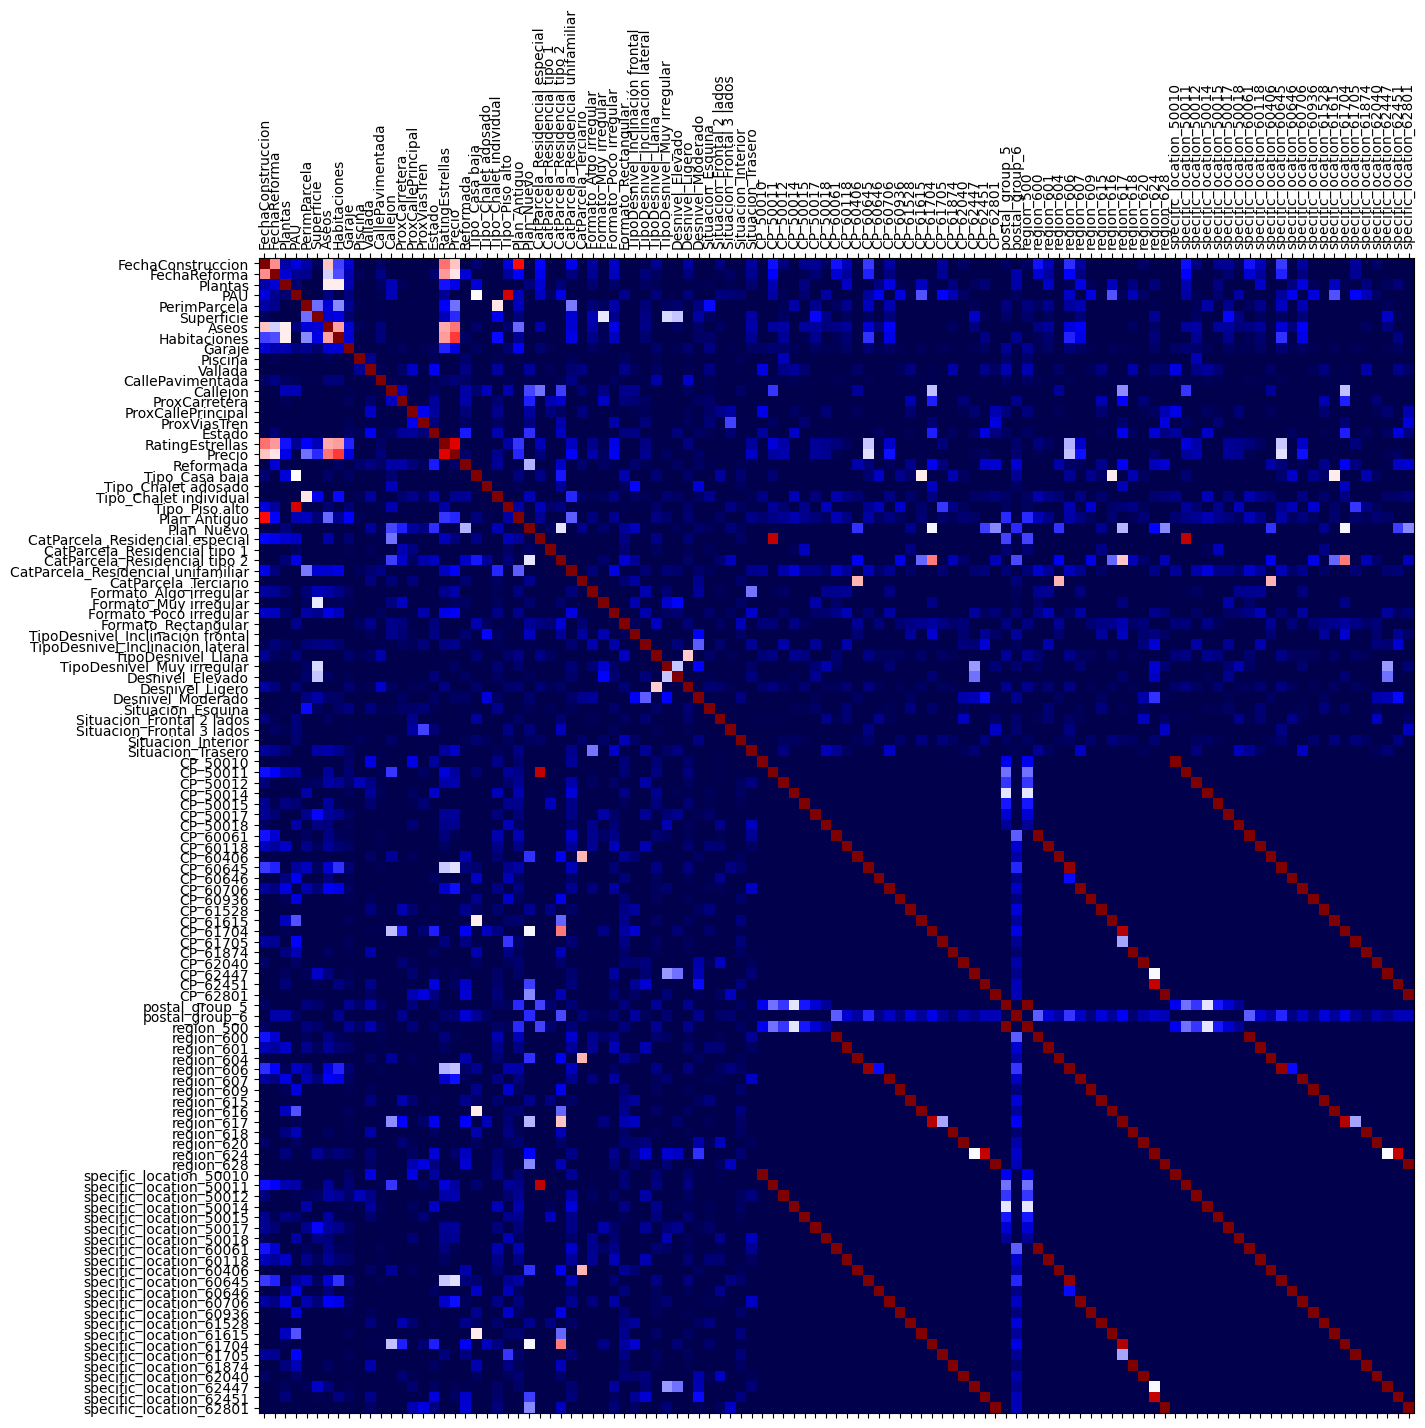

In [5]:
# plot correlation matrix of columns in the dataframe
def plot_correlation_matrix(df):
    corr = df.corr()
    #sort the correlation, place the most correlated variables next to price
    print(corr)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

plot_correlation_matrix(df)

In [6]:
def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

train_size = 0.9
train = df.sample(frac=train_size, random_state=1)
test = df.drop(train.index)

X_train, y_train = x_y_split(train, 'Precio')
X_test, y_test = x_y_split(test, 'Precio')
X_train.head()

,FechaConstruccion,FechaReforma,Plantas,PAU,PerimParcela,Superficie,Aseos,Habitaciones,Garaje,Piscina,...,specific_location_60936,specific_location_61528,specific_location_61615,specific_location_61704,specific_location_61705,specific_location_61874,specific_location_62040,specific_location_62447,specific_location_62451,specific_location_62801
875,0.982686,0.899805,1.280128,-0.387936,0.159925,-0.137401,0.537665,2.891479,0.176781,-0.039968,...,0,0,0,0,0,0,0,0,0,0
35,0.878233,0.795678,1.280128,-0.387936,1.520991,0.307971,1.612996,1.610017,0.176781,-0.039968,...,0,0,0,0,0,0,0,0,0,0
63,-2.011648,-2.067831,1.280128,-0.387936,-0.871277,-0.006352,-0.537665,1.610017,0.176781,-0.039968,...,0,0,0,1,0,0,0,0,0,0
957,-0.584117,-1.443065,-0.779924,-0.387936,-0.046451,-0.296684,-1.612996,-0.312177,0.176781,-0.039968,...,0,0,0,0,0,0,0,0,0,0
590,0.878233,0.743614,1.280128,-0.387936,-0.293763,-0.205958,0.537665,-0.312177,0.176781,-0.039968,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred

def visualize_test(y_test, y_pred, ax, model_name):
    paired = sorted(list(zip(y_test, y_pred)))
    y_test_sorted, y_pred_sorted = zip(*paired)
    y_test_sorted = zscore_norm_price_inverse(np.array(y_test_sorted))
    y_pred_sorted = zscore_norm_price_inverse(np.array(y_pred_sorted))

    mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
    # print in scientific notation format
    print('MAE: {:.2e}'.format(mae))
    # plot y_test and y_pred values to visualize the model performance
    num_range = np.arange(0, len(y_test))
    ax.plot(y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()

MAE: 4.64e+04


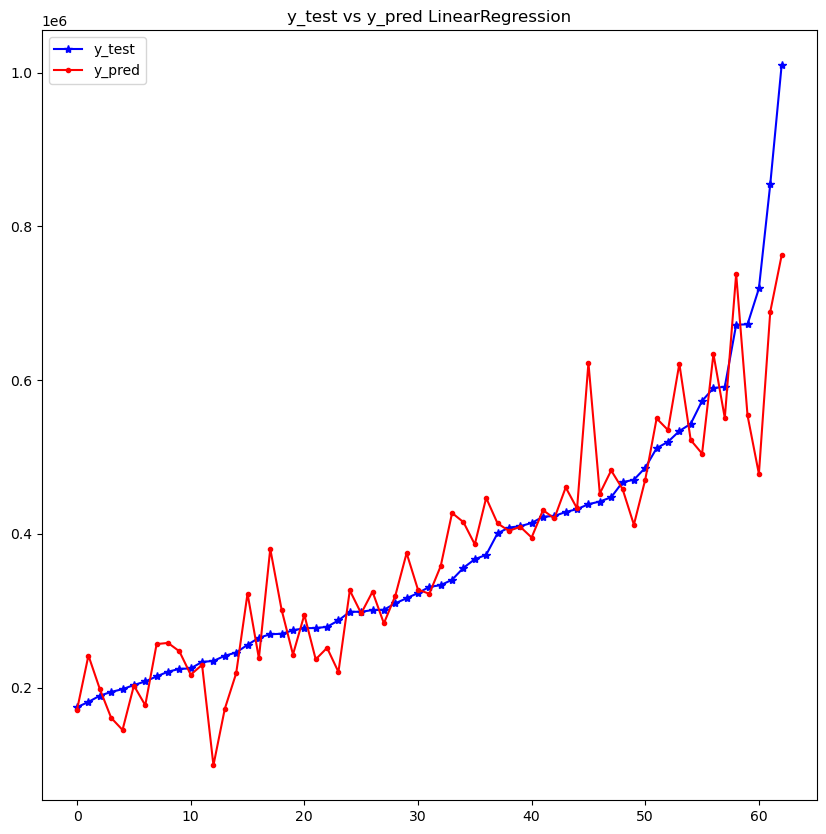

In [8]:
best_combination = {'recall': 0, 'model': None, 'norm': None, 'sampling': None, 'trained_model': None}
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

model = LinearRegression()
model_name = model.__class__.__name__
trained_model = train_model(model, X_train, y_train)
y_pred = test_model(trained_model, X_test, y_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)

MAE: 4.64e+04
MAE: 1.01e+05
MAE: 1.26e+05
MAE: 4.73e+04
MAE: 6.08e+04
MAE: 4.97e+04
MAE: 4.96e+04
MAE: 5.40e+04


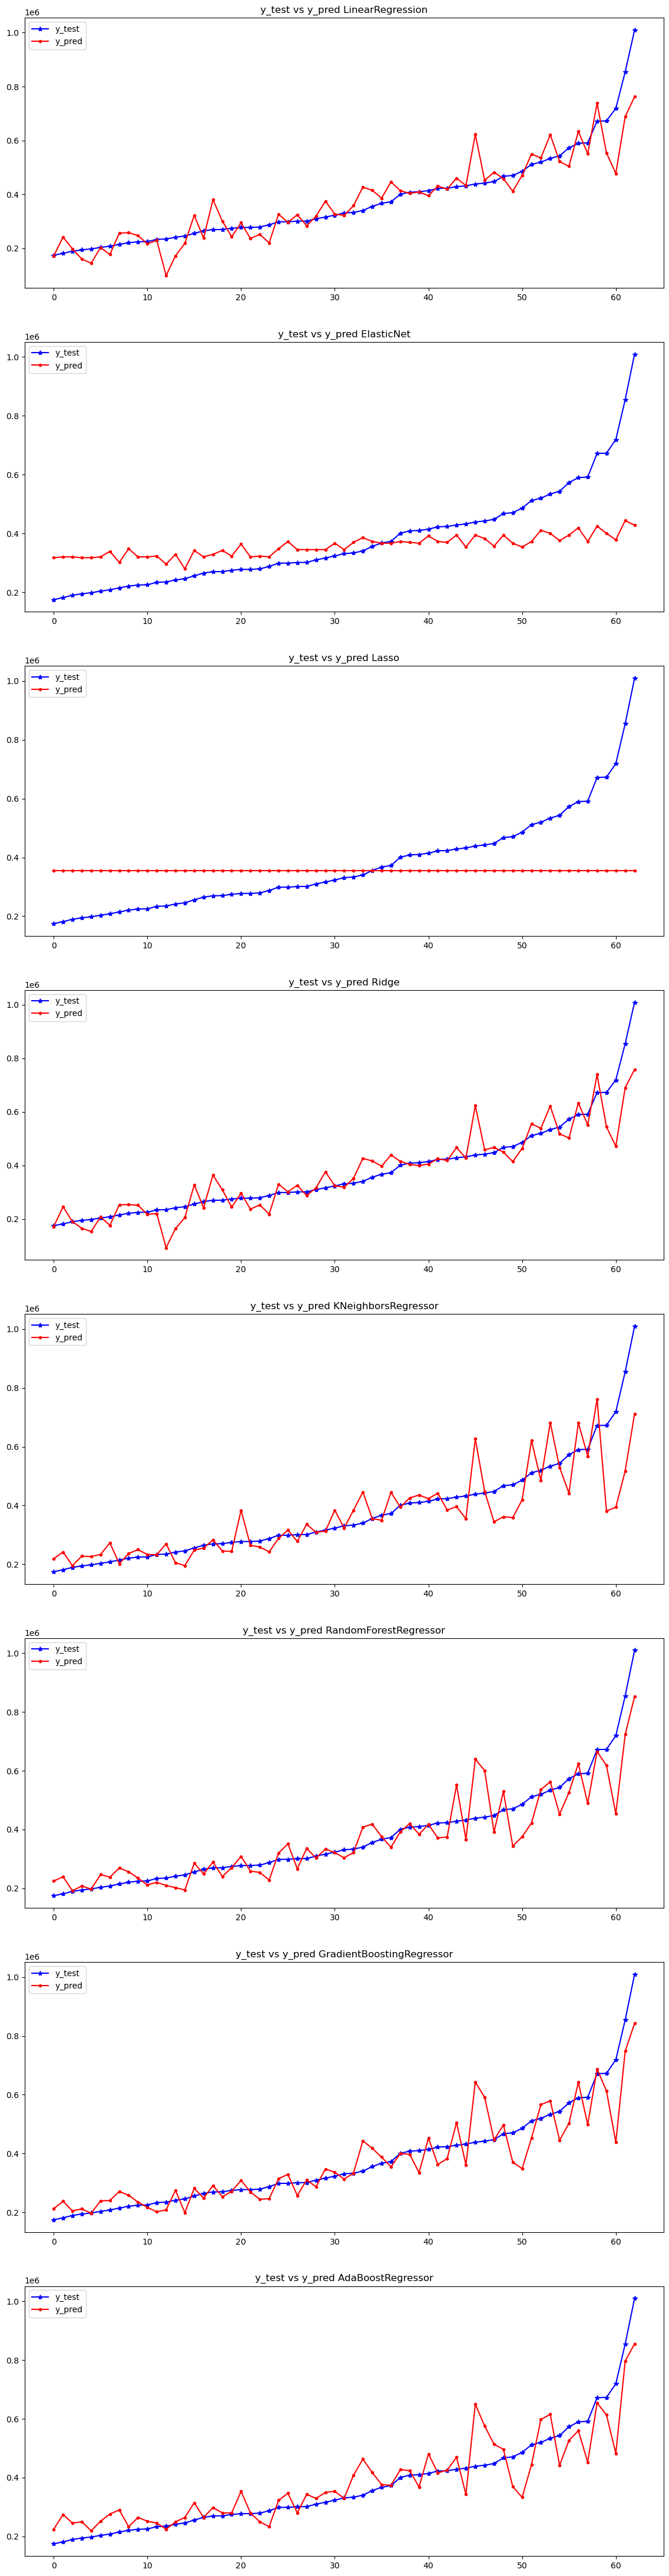

In [9]:
models = [LinearRegression(), ElasticNet(), Lasso(), Ridge(), KNeighborsRegressor(), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)

plt.show()


In [10]:
grad_boost = GradientBoostingRegressor()

distributions = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 7),
    'min_samples_split': uniform(0.01, 0.2),
    'min_samples_leaf': uniform(0.01, 0.1),
    'subsample': uniform(0.8, 0.2),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

clf = RandomizedSearchCV(grad_boost, distributions, random_state=0, n_iter=10000, verbose=1, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


{'learning_rate': 0.063946238593406,
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 0.019226434757784773,
 'min_samples_split': 0.1424134826795161,
 'n_estimators': 847,
 'subsample': 0.8383448219843692}

MAE: 4.45e+04


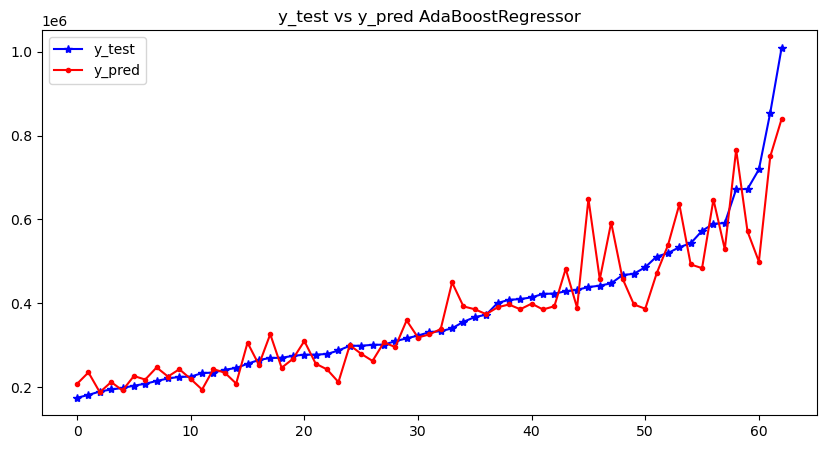

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)